# Programming for Data Science and Artificial Intelligence

## Deep Learning -  PyTorch III - Convolutional Neural Network

- [WEIDMAN] Ch7
- https://pytorch.org/tutorials/
- https://github.com/yunjey/pytorch-tutorial

In [1]:
import torch, torchvision
from torchvision import transforms
from torch import nn
import numpy as np
import sys

Last class we use linear network for classifying MNIST data.  Today we shall propose CNN (Convolutional Neural Network) as a better way for dealing with image classification.

There are mainly three layers that can help dealing with images:

1. Convolutional layer
2. Max/Average pooling layer
3. BatchNorm layer
4. Dropout layer

### 1. Convolutional Layer
Let's say given a image of 14 x 14 pixels = 196 features like this.  Each data point is an array of numbers describing how dark each pixel is, where value range from 0 to 255.  These values can be normalized ranging from 0 to 1. For example, for the following digit (the digit 1), we could have:

<img src ="../figures/one.png" width="250">

It is first important to define the input shape of an image, which will be <code>(input channels, image height, image width)</code>.  If we have lots of images, the input shall be <code>(batch size, input channels, image height, image width)</code>.  For our case, if it is a grayscale image, the shape is <code>(1, 14, 14)</code>.  If it is a RGB image, it shall be <code>(3, 14, 14)</code>.  If it is a CMYK, it shall be <code>(4, 14, 14)</code>.  If I define batch size as 500 (out of many more images I have), my input is <code>(500, 4, 14, 14)</code>.  (Commonly, batch size is around few hundreds).

Convolutional network works on the central concept of a convolution operation like this:

<img src ="../figures/no_padding_no_strides.gif" width="150">

Mathematically, it looks like this:

Let's say we have a 5 x 5 input image $I$ of channel 0 of batch 0:

$$ I = \begin{bmatrix}
i_{11} & i_{12} & i_{13} & i_{14} & i_{15}
\\
i_{21} & i_{22} & i_{23} & i_{24} & i_{25}
\\
i_{31} & i_{32} & i_{33} & i_{34} & i_{35}
\\
i_{41} & i_{42} & i_{43} & i_{44} & i_{45}
\\
i_{51} & i_{52} & i_{53} & i_{54} & i_{55}
\end{bmatrix}
$$

Each of this pixel may represent the brightness ranging from 0 to 255.  Or if normalized, shall be 0 to 1.

If we define a 3 x 3 patch which we commonly called **weights (W)** or in computer vision, we called **filters/kernels** like this (*we shall called filters in this lecture note for simplicity*) :

$$ W = \begin{bmatrix}
w_{11} & w_{12} & w_{13}
\\
w_{21} & w_{22} & w_{23}
\\
w_{31} & w_{32} & w_{33}
\end{bmatrix}
$$

Let's say we are scanning the middle of the image, then the output feature would be (we'll denote this as $o_{33}$):

$$o_{33} = w_{11} * i_{22} + w_{12} * i_{23} + w_{13} * i_{24} + \
           w_{21} * i_{32} + w_{22} * i_{32} + w_{23} * i_{34} + \
           w_{32} * i_{43} + w_{33} * i_{44}$$
           
This will result in one output feature called **feature map**.  Of course, we may add bias to it and then will be fed through an activation function.

Actual feature maps look like this.  Each feature map is a output of a single training example and convolve each kernel over the sample.    In simple words, if we have $k$ filters, then we have $k$ feature maps.  They represent the activation part corresponding to the kernels.

<img src ="../figures/feature-map2.png" width="450">

In a convolution operation, there are 3 main hyperparameters to fine tune - (1) filter size, (2) padding, and (3) stride.

#### A. Filters

1. **How the filters look like?**.  It turns out that each filter actually detect the presence of certain visual pattern.  For example, this filter below detects whether there is an edge at that location of the image.  There are also other similar filters detecting corners, lines, etc.  Check out https://setosa.io/ev/image-kernels/  and try changing the values

$$ w = \begin{bmatrix}
0 & 1 & 0
\\
1 & -4 & 1
\\
0 & 1 & 0
\end{bmatrix}
$$

Real filters can look like this.  They may look somewhat random at first glance, but we can see that clear structure being learned in most kernels. For example, filters 3 and 4 seem to be learning diagonal edges in opposite directions, and other capture round edges or enclosed spaces:

<img src ="../figures/kernels.png" width="200">

However, **it is important to note that we DON'T need to decide the filters** to use.  We can simply feed a random generated filter, and it is the job of CNN to learn these filters.   These learned filters will learn what features are most efficient for the classification process.

**What is the shape of filters?**.  For each image, we can apply multiple filters, depending on how many output channels we want.  Let's say the input channel is 3, and we want the output channel to 64, then we apply a filter of size <code>(3, 64, filter width, filter height)</code>.  How do we know how many output channel to use? The answer is we don't know...we just try and see what works.  More filter allows the network to look at more patterns.

**What should be the filter size?**  If we use a 3 x 3 filter, each pixel got 8 neighboring information.  On the other hand, if we we use big filter like 9 x 9, then we got 80 neighboring information.  Typical size is 3 and 5.


#### B. Padding

2. **How should we convolve the edges?**. Recall this image:

<img src ="../figures/no_padding_no_strides.gif" width="150">

It has 4 x 4 pixels = 16 features.  But after convolution, we only got 2 x 2 pixels = 4 features left.  Is that good?  There are no correct answers here but we are quite sure that we lose some information.  One way is address this is **padding**, where we can enlarge the input image by padding the surroundings with zeros.  How much?  Padding until we get the original size or larger size, for example, like this.  The below put zero padding around which result the output features to be the same size as input features.

<img src ="../figures/same_padding_no_strides.gif" width="150">

The below put even more padding which pad to make sure each single pixel is convoluted (full padding), which result the output features to be even large

<img src ="../figures/full_padding_no_strides.gif" width="150">

#### C. Strides

3. **How many step we should take to slide our filter? Skip 2?** Should we shift 1 step per convolution, or 2 steps, or how many steps.  **In fact, it really depends on how detail you want it to be.  But defining bigger steps reduce the feature size and thus reduce the computation time.**  Bigger step is like human scanning picture more roughly but can reduce the computation time....whether to use it is something to be experimented though. 

In computer vision, we called this step as **stride**.  Example is like this:

**No padding with stride of 2**

<img src ="../figures/no_padding_strides.gif" width="150">

**Padding with stride of 2**

<img src ="../figures/padding_strides.gif" width="150">

Actual image convolution can look like this (with stride 1 and no padding):

<img src ="../figures/conv.gif" width="400">

The convoluted image may look like this (nothing relate with the above matrix though):

<img src ="../figures/convimages.png" width="400">

**The formula to be used to measure the padding value to get the spatial size of the input and output volume to be the same with stride 1** is

$$ \frac{K-1}{2} $$

where $K$ is the filter size.

This means that if our image is size $24 * 24$, and the filter size is $3 x 3$, then our $K$ has size 3 so the padding should be $(3-1)/2 = 1$, then we need to add **a border of one pixel valued 0 around the outside of the image**, which would result in the input image of size $26 * 26$

#### D. Shape

4. **What would be the shape of the output matrix?**

The output shape (denote as $O$) depend on the stride (denote as $S$), padding (denote as $P$), filter size (denote as $F$) as well as the input width and height (denote as $I$). $O$ can be calculated with the formula as follows:

$$O = \frac{W-F+2P}{S} + 1$$

In this case (code below), if our W is 28, F is 5, P is 2, and S is 1 then the width/height is 28

In conclusion, 

- The input will have a 4D shape of <code>(batch size, input channels, input height, input width)</code>

- The output will have a 4D shape of <code>(batch size, output channels, output height, output width)</code>

- The convolutional filters will have 4D shape of <code>(input channels, output channels, filter height, filter width)</code>

**Note: The order does not matter and it depends on the python library you use but these four dimensions always exist in CNN.**

### 2. Max/Average Pooling Layer

Talking about **reducing computation time**, a common way is to perform a **pooling layer** which simply downsample the image by average a set of pixels, or by taking the maximum value.  If we define a pooling size of 2, this involves mapping each 2 x 2 pixels to one output, like this:

<img src ="../figures/pooling.png" width="150">

Nevertheless, pooling has a really big downsides, i.e., it basically lose a lot of information.  Compared to strides, strides simply scan less but maintain the same resolution but pooling simply reduce the resolution of the images....As Geoffrey Hinton said on Reddit AMA in 2014 - **The pooling operation used in CNN is a big mistake and the fact that it works so well is a disaster**.  In fact, in most recent CNN architectures like ResNets, it uses pooling very minimially or not at all.

### 3. BatchNorm Layer

Batch norm is nothing other than normalize samples within the batch.  That is, minus the mean of features within the batch.  This helps with vanishing graidents, as well as keep the neural network more stable. Note that the output size does not change from input size after BatchNorm.


### 4. Dropout Layer

This is a layer of arbitrarily removing some values in your data.  By randomly removing data in each iteration, you make the neural network more robust against overfitting, because it needs to learn to fight with incomplete data.

For example, say we have a vector of $x = {1, 2, 3, 4, 5}$.  Let's set $p=0.2$ which means 20\% of data will be turn to 0.  In training mode, $x_\text{train} = {1, 0, 3, 4, 5}$ ; do not confuse why I turn off 2 and not others, I just turn 20\% off randomly.  In evaluation mode, we turn off dropout, but to make sure the distribution remains similar, we multiply the values by $1 - 0.2 = 0.8$, which becomes $x_\text{inference} = {0.8, 1.6, 2.4, 3.2, 4.0}$

### Demo

https://www.cs.ryerson.ca/~aharley/vis/conv/

### Code

Here we will be exploring how to use pyTorch for CNN.

In [2]:
# Hyper parameters
num_epochs = 1
num_classes = 10
batch_size = 10
learning_rate = 0.001

#set gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #in_channel = 1
            #out_channel = 16
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #after layer 1 will be of shape [100, 16, 14, 14]
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #after layer 2 will be of shape [100, 32, 7, 7]
        self.fc = nn.Linear(32*7*7, num_classes)
        self.drop_out = nn.Dropout(p=0.2)  #zeroed 0.2% data
        #after fc will be of shape [100, 10]
        
    def forward(self, x):
        #x shape: [batch, in_channel, img_width, img_height]
        #[100, 1, 28, 28]
        out = self.layer1(x)
        out = self.drop_out(out)
        #after layer 1: shape: [100, 16, 14, 14]
        out = self.layer2(out)
        out = self.drop_out(out)
        #after layer 2: shape: [100, 32, 7, 7]
        out = out.reshape(out.size(0), -1)   #can also use .view()
        #after squeezing: shape: [100, 1568]
        #we squeeze so that it can be inputted into the fc layer
        out = self.fc(out)
        #after fc layer: shape: [100, 10]
        return out


Define the model

In [4]:
model = ConvNet(num_classes).to(device)

Define the loss and optimizer

In [5]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #con2d expects (batch, channel, width, height)
        images = images.to(device)
        labels = labels.to(device)
        
        #print(images.size())
        #print(labels.size())
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            sys.stdout.write ('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/1], Step [6000/6000], Loss: 0.0202

In [7]:
# Test the model
model.eval()  # eval mode will turn off the dropout; good to explicitly call when you test
all_labels = []
all_predicted = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.append(labels.numpy())  #for plotting
        all_predicted.append(predicted.numpy())

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'models/cnn.ckpt')

Test Accuracy of the model on the 10000 test images: 98.31 %


In [8]:
all_labels = np.array(all_labels).flatten()
all_predicted = np.array(all_predicted).flatten()

(all_labels == all_predicted).sum()

9831

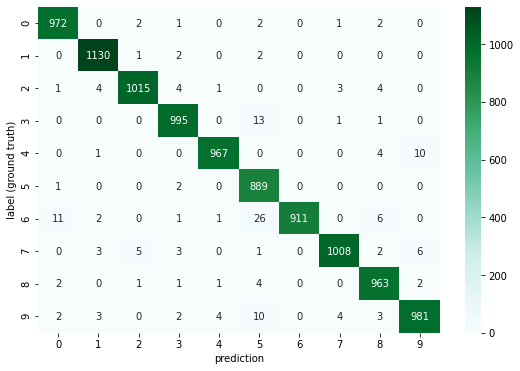

In [9]:
# Display the confusion matrix as a heatmap
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

arr = confusion_matrix(all_labels, all_predicted)
class_names = np.arange(10)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

### Task

- Try to load the CIFAR dataset and test your network

<code>train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
</code>